In [502]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time
import numpy as np


In [503]:
rootfolder = '../'


Useful function for plot a 2D dictionary

In [504]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [ ]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    r = s.copy().flatten()
    omega = []

    if np.linalg.norm(r) < tau:
        return x
    
    while np.linalg.norm(r) > tau and np.count_nonzero(x) < L:
        eps = np.zeros(N)
        for j in range(N):
            if j in omega:
                continue
            d_j = D[:, j]
            d = np.dot(r.T, d_j)**2/np.linalg.norm(d_j)
            eps[j] = d
        jStar = np.argmax(eps)
        omega.append(jStar)
        D_omega = D[:, omega]
        coeffs_omega = np.linalg.lstsq(D_omega, s.flatten(), rcond=None)[0]
        x[omega] = coeffs_omega
        r = s.flatten() - D_omega @ coeffs_omega
    return x

Load the image and rescale it in $[0,1]$

In [506]:
img = imread(f'{rootfolder}/data/peppers256.png') / 255
# img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Corrupt the image with white gaussian noise

In [507]:
sigma_noise = 20/255
noisy_img = img + np.random.random(size=imsz) * sigma_noise

Percentage of removed pixel

In [508]:
perc_of_removed_pixels = 0.25

Arbitrarily remove pixels setting them to zero

In [509]:
# create a vector with all the indexes of the image
idx = np.arange(img.size)

# shuffle it and take the target percentage of indexes
selected_indexes = np.random.choice(
    img.size,
    size=int(0.25*img.size),
    replace=False
)

# the mask is 0 for the chosen idx, 1 elsewhere
msk = np.ones_like(img.flatten())
msk[selected_indexes] = 0
msk = msk.reshape(img.shape)

# apply the mask: set to 0 some elements in the noisy image
noisy_img = noisy_img * msk


Compute the psnr of the noisy input

In [510]:
def psnr(img1, img2, max_pixel=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

In [511]:
psnr_noisy = psnr(img, noisy_img)


Text(0.5, 1.0, 'Dead pixels')

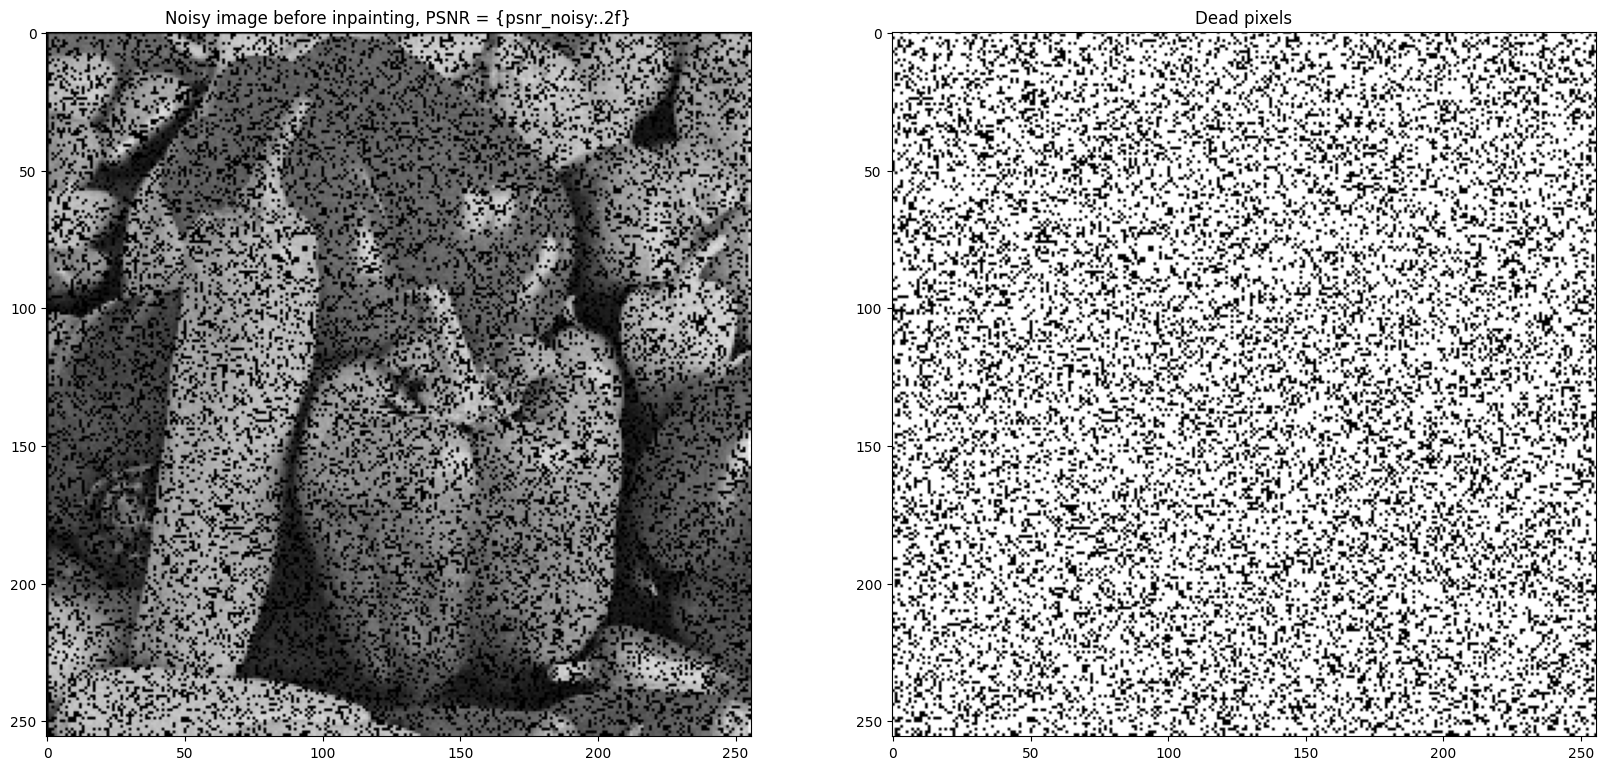

In [512]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(noisy_img, cmap='gray')
ax[0].set_title('Noisy image before inpainting, PSNR = {psnr_noisy:.2f}')

ax[1].imshow(msk, cmap='gray')
ax[1].set_title(f'Dead pixels')


Load and display the dictionary learned from patches

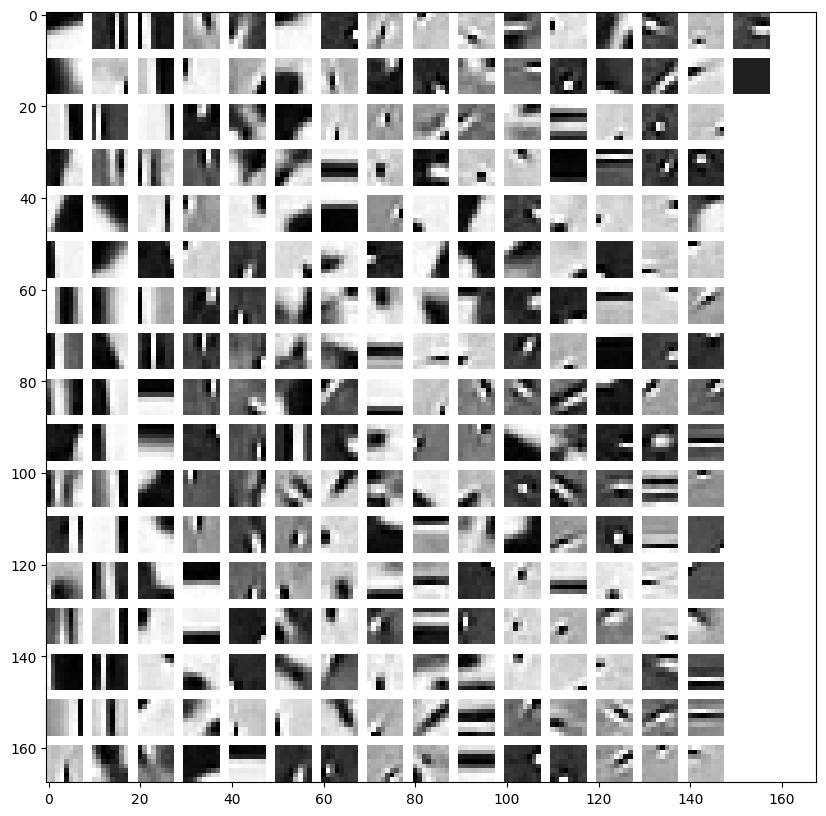

In [513]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# add a constant atom to D, KSVD was trained over patches with zero mean - and normalize it
constant_atom = np.ones((M, 1))
constant_atom /= np.linalg.norm(constant_atom)
D = np.concatenate([D, constant_atom], axis=1)
norms = np.linalg.norm(D, axis=0, keepdims=True)
D = D / np.where(norms > 1e-10, norms, 1)

# display the dictionary
D_img = get_dictionary_img(D)

plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')

Inpainting
----------


In [514]:
# SET stopping criteria of OMP
# orthogonal matching pursuit uses sparsity and errors as stopping criteria
L = M / 2

# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# define the step (=p for non overlapping paches)
# STEP = 4 
STEP = 1 # might be very time consuming, start with larger STEP

Operate patchwise

In [ ]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i : i + p, j : j + p]

        # patch extracted from the mask
        m = msk[i : i + p, j : j + p]

        # design the projection operator over the current patch
        valid_index = np.where(m.flatten() == 1)[0]
        # proj = np.diag(m.flatten())

        # tau should be proportional to the number of pixels remaining in the patch
        tau = sigma_noise * np.sqrt((1 - perc_of_removed_pixels) * img.size) * 1.15

        # sparse coding w.r.t. PD the inpainted dictionary using L and tau as stopping criteria
        projected_dict = D[valid_index, :]
        projected_norms = np.linalg.norm(projected_dict, axis=0, keepdims=True)
        projected_dict = projected_dict
        projected_patch = s.flatten()[valid_index]
        x = OMP(projected_patch, projected_dict, int(L), tau)
        # x = OMP(s, D, int(L), tau)

        # Add after OMP call:
        print(
            f"Patch ({i},{j}): valid_pixels={np.sum(m)}, tau={tau:.6f}, ||x||={np.linalg.norm(x):.6f}"
        )
        if i == 0 and j == 0:  # Debug first patch
            print(f"First patch stats:")
            # print(f"  Projected patch norm: {np.linalg.norm(projected_patch):.6f}")
            print(f"  Selected atoms: {np.sum(x > 1e-6)}")
            print(f"  Reconstruction norm: {np.linalg.norm(s_hat):.6f}")

        # reconstruction: synthesis w.r.t. D the dictionary yielding sparse representation
        s_hat = D @ x

        # use uniform weights for aggregation
        w = 1

        # put the denoised patch into the estimated image using uniform weights
        img_hat[i : i + p, j : j + p] += w * s_hat.reshape((p, p))

        # store the weight of the current patch in the weight matrix
        weights[i : i + p, j : j + p] += w

Patch (0,0): valid_pixels=46.0, tau=19.996696, ||x||=0.000000
First patch stats:
  Selected atoms: 0
  Reconstruction norm: 0.000000
Patch (0,1): valid_pixels=47.0, tau=19.996696, ||x||=0.000000
Patch (0,2): valid_pixels=46.0, tau=19.996696, ||x||=0.000000
Patch (0,3): valid_pixels=48.0, tau=19.996696, ||x||=0.000000
Patch (0,4): valid_pixels=48.0, tau=19.996696, ||x||=0.000000
Patch (0,5): valid_pixels=50.0, tau=19.996696, ||x||=0.000000
Patch (0,6): valid_pixels=50.0, tau=19.996696, ||x||=0.000000
Patch (0,7): valid_pixels=53.0, tau=19.996696, ||x||=0.000000
Patch (0,8): valid_pixels=54.0, tau=19.996696, ||x||=0.000000
Patch (0,9): valid_pixels=54.0, tau=19.996696, ||x||=0.000000
Patch (0,10): valid_pixels=54.0, tau=19.996696, ||x||=0.000000
Patch (0,11): valid_pixels=54.0, tau=19.996696, ||x||=0.000000
Patch (0,12): valid_pixels=56.0, tau=19.996696, ||x||=0.000000
Patch (0,13): valid_pixels=53.0, tau=19.996696, ||x||=0.000000
Patch (0,14): valid_pixels=53.0, tau=19.996696, ||x||=0.0

Normalize the estimated image with the computed weights

In [516]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

In [517]:
psnr_hat = psnr(img, img_hat)

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 5.58')

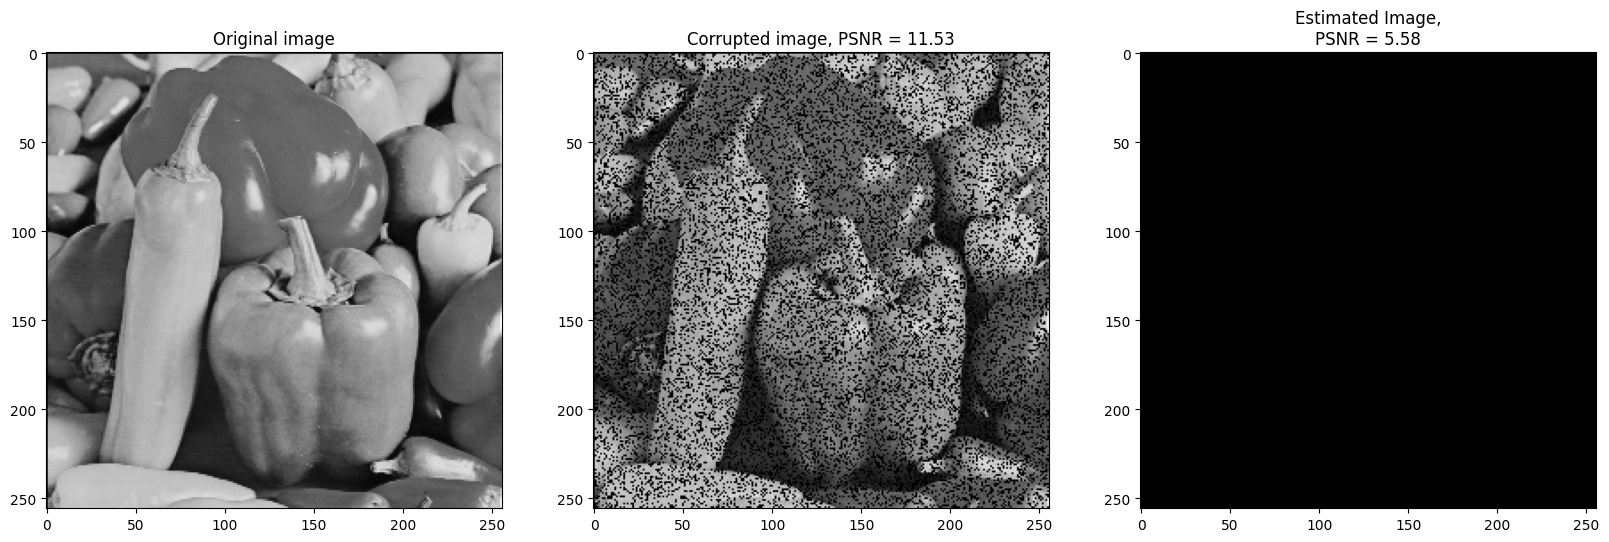

In [518]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

ax[0].imshow(img, cmap='gray')
ax[0].set_title(f'Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Corrupted image, PSNR = {psnr_noisy:.2f}')

ax[2].imshow(img_hat, cmap='gray')
ax[2].set_title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
